In [9]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from Bio import SeqIO
import matplotlib.pyplot as plt
import os
import seaborn as sns
import imageio
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [11]:
# -------------------------------
# Step 1: Load and encode FASTA
# -------------------------------
def one_hot_encode_seq(seq, max_len):
    """One-hot encode protein sequence (Amino acids A-Z)"""
    amino_acids = "ACDEFGHIKLMNPQRSTVWY"
    aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}
    encoding = np.zeros((max_len, len(amino_acids)), dtype=np.float32)
    for i, aa in enumerate(seq):
        if i >= max_len:
            break
        if aa in aa_to_int:
            encoding[i, aa_to_int[aa]] = 1.0
    return encoding

def parse_ss2_file(filepath):
    aa_seq = []
    ss_seq = []
    with open(filepath, 'r') as f:
        for line in f:
            if line.startswith('#') or not line.strip():
                continue
            parts = line.split()
            if len(parts) >= 3:
                aa_seq.append(parts[1])  # amino acid
                ss_seq.append(parts[2])  # secondary structure
    ss_seq = [s.replace('E', 'B') for s in ss_seq]
    return "".join(aa_seq), "".join(ss_seq)

def get_secondary_structure_from_ss2_file(folder_path, filename):
    filepath = os.path.join(folder_path, filename)
    _, ss_seq = parse_ss2_file(filepath)
    return ss_seq

In [13]:
# Load sequences from FASTA
fasta_path = "sequence.fasta"
ss_folder_path = r'Protein Structures'
records = list(SeqIO.parse(fasta_path, "fasta"))
max_len = max(len(record.seq) for record in records)  # pad to longest sequence

X = np.array([one_hot_encode_seq(str(record.seq), max_len) for record in records])
y_ss = np.array([get_secondary_structure_from_ss2_file(ss_folder_path, record.id + ".ss2") for record in records])

# Map secondary structure to integer labels
ss_map = {'H': 0, 'C': 1, 'B': 2}
y_labels = np.array([
    [ss_map.get(s, 1) for s in ss][:max_len] + [1]*(max_len - len(ss))  # pad with 'C' (1) if needed
    for ss in y_ss
])

num_classes = 3
y_cat = to_categorical(y_labels, num_classes=num_classes)

In [15]:
# -------------------------------
# Step 3: Train/Val/Test split
# -------------------------------
X_train, X_temp, y_train, y_temp = train_test_split(X, y_cat, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [17]:
# -------------------------------
# Step 4: Build CNN Model
# -------------------------------
model = Sequential([
    Conv1D(64, kernel_size=3, activation="relu", padding="same", input_shape=(max_len, X.shape[2])),
    Dropout(0.3),
    Conv1D(128, kernel_size=3, activation="relu", padding="same"),
    Dropout(0.3),
    Conv1D(num_classes, kernel_size=1, activation="softmax", padding="same")  # per-residue prediction
])

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

# -------------------------------
# Step 4.5: Callback for Weight GIFs
# -------------------------------
class WeightsGIFCallback(Callback):
    def __init__(self, save_dir="weights_frames"):
        super().__init__()
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)
        self.epoch_frames = []

    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.layers[0].get_weights()[0]  # Conv1D kernel
        plt.figure(figsize=(6, 4))
        sns.heatmap(weights[:, 0, :], cmap="viridis")
        plt.title(f"Conv1D Weights - Epoch {epoch+1}")
        frame_path = os.path.join(self.save_dir, f"epoch_{epoch+1}.png")
        plt.savefig(frame_path)
        plt.close()
        self.epoch_frames.append(frame_path)

    def on_train_end(self, logs=None):
        gif_path = os.path.join(self.save_dir, "weights_evolution.gif")
        with imageio.get_writer(gif_path, mode='I', duration=0.5) as writer:
            for frame in self.epoch_frames:
                writer.append_data(imageio.imread(frame))
        print(f"GIF saved at {gif_path}")

gif_callback = WeightsGIFCallback()

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)               │ (None, 1237, 64)       │         3,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1237, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 1237, 128)      │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 1237, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1237, 3)        │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,995 (113.26 KB)

 Trainable params: 28,995 (113.26 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# -------------------------------
# Step 5: Train
# -------------------------------
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=8,
    callbacks=[gif_callback]
)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 194ms/step - accuracy: 0.3077 - loss: 1.0905 - val_accuracy: 0.6995 - val_loss: 1.0498
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7907 - loss: 1.0592 - val_accuracy: 0.6985 - val_loss: 1.0155
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7880 - loss: 1.0300 - val_accuracy: 0.6982 - val_loss: 0.9856
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7894 - loss: 1.0019 - val_accuracy: 0.6982 - val_loss: 0.9611
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.7958 - loss: 0.9743 - val_accuracy: 0.6982 - val_loss: 0.9422
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.7820 - loss: 0.9549 - val_accuracy: 0.6982 - val_loss: 0.9273
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7909 - loss: 0.9268 - val_accuracy: 0.6982 - val_loss: 0.9144
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.7895 - loss: 0.9026 - val_accuracy: 0.6982 - v

/var/folders/1d/0vd5nycs4cbdgbwm61w1ch340000gn/T/ipykernel_10772/3248924944.py:39: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  writer.append_data(imageio.imread(frame))


GIF saved at weights_frames/weights_evolution.gif


In [21]:
# -------------------------------
# Step 6: Evaluate
# -------------------------------
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9291 - loss: 0.1832
Test Accuracy: 92.91%


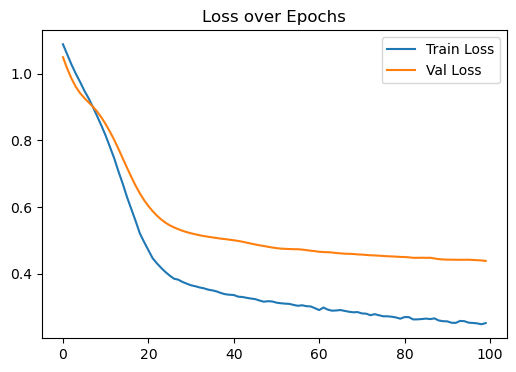

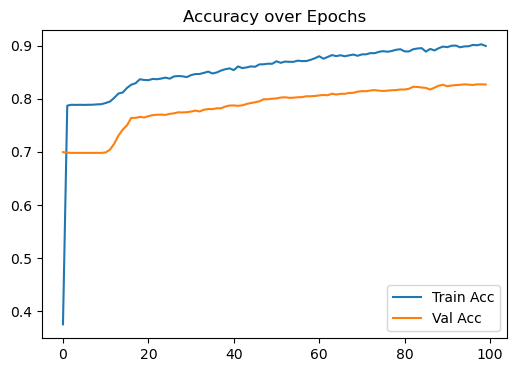

In [23]:
# -------------------------------
# Step 7: Plot loss and accuracy
# -------------------------------
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss over Epochs")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy over Epochs")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


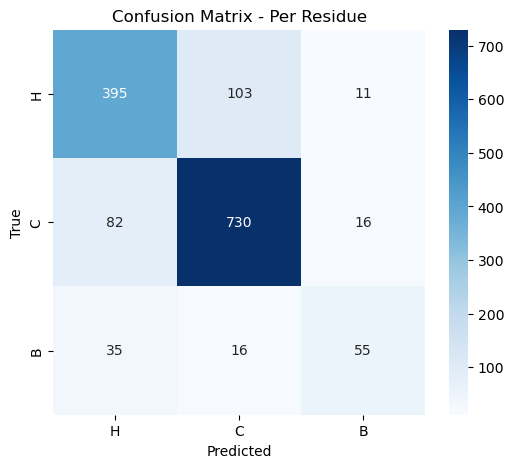

Classification Report:
              precision    recall  f1-score   support

           H       0.77      0.78      0.77       509
           C       0.86      0.88      0.87       828
           B       0.67      0.52      0.59       106

    accuracy                           0.82      1443
   macro avg       0.77      0.73      0.74      1443
weighted avg       0.81      0.82      0.82      1443

Per-residue Accuracy: 81.77%


In [25]:
# -------------------------------
# Step 8: Confusion Matrix & Metrics
# -------------------------------

# Predict on test set
y_pred_probs = model.predict(X_test)  # shape: (samples, max_len, num_classes)
y_pred_classes = np.argmax(y_pred_probs, axis=-1)
y_true_classes = np.argmax(y_test, axis=-1)

# Flatten sequences for per-residue classification metrics
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

# Remove padding positions (optional)
mask = ~(np.all(X_test == 0, axis=2).flatten())  # True for real residues
y_pred_flat = y_pred_flat[mask]
y_true_flat = y_true_flat[mask]

# Confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=['H', 'C', 'B'],
            yticklabels=['H', 'C', 'B'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Per Residue")
plt.show()

# Classification metrics
print("Classification Report:")
print(classification_report(y_true_flat, y_pred_flat, target_names=['H', 'C', 'B']))

# Accuracy
acc = accuracy_score(y_true_flat, y_pred_flat)
print(f"Per-residue Accuracy: {acc*100:.2f}%")